
Evaluación del modelo XGBoost (2015–2018):
RMSE: 0.81
R²: 0.43

📊 Ventas reales por país (2015–2018):
Argentina - 2015: $32,626.00
Argentina - 2016: $31,991.00
Argentina - 2017: $48,800.00
Argentina - 2018: $91,745.00
Argentina - 2019 (estimado): $732,254.38

México - 2015: $471,317.00
México - 2016: $654,920.00
México - 2017: $632,898.00
México - 2018: $702,528.00
México - 2019 (estimado): $734,513.38

Brasil - 2015: $194,869.00
Brasil - 2016: $330,496.00
Brasil - 2017: $301,453.00
Brasil - 2018: $457,296.00
Brasil - 2019 (estimado): $704,197.31



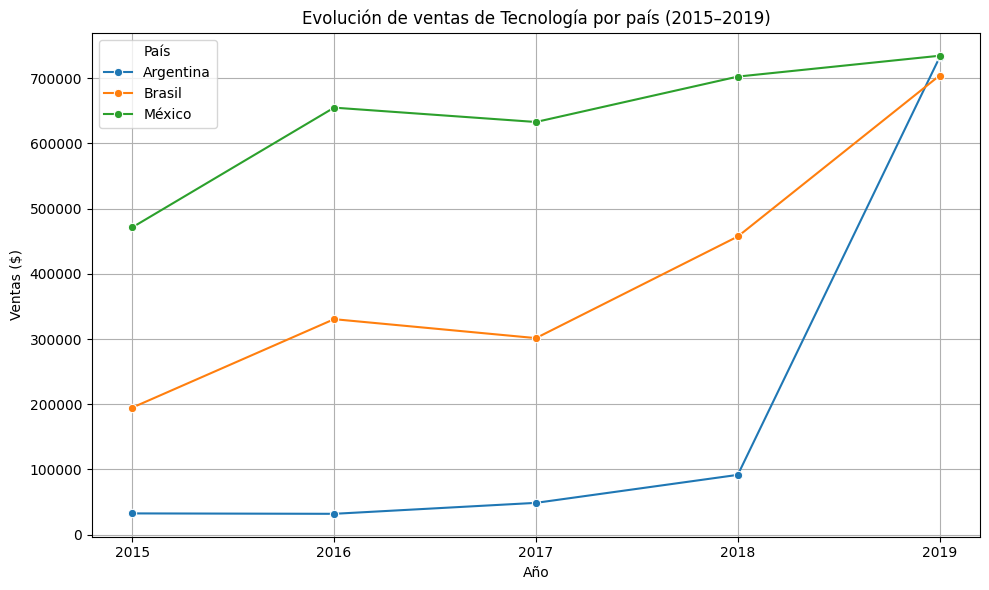

Crecimiento interanual de ventas por país (2015–2019):

Argentina:
2015 → 2016: -1.95%
2016 → 2017: 52.54%
2017 → 2018: 88.00%
2018 → 2019: 698.14%

México:
2015 → 2016: 38.96%
2016 → 2017: -3.36%
2017 → 2018: 11.00%
2018 → 2019: 4.55%

Brasil:
2015 → 2016: 69.60%
2016 → 2017: -8.79%
2017 → 2018: 51.70%
2018 → 2019: 53.99%


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score


df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTXozjkuDg6tdEVyyVGZhzdCHwwLTWdl5T0jyc7acdwHZgPGpyYcPGbMvuLPmPqew/pub?gid=1933466057&single=true&output=csv')
df["Fecha del pedido"] = pd.to_datetime(df["Fecha del pedido"], dayfirst=True)

#Filtrar categoría Tecnología y países relevantes
df_tecnologia = df[(df["Categoría"] == "Tecnología") &
                   (df["País"].isin(["Argentina", "México", "Brasil"]))].copy()

# 3. Ingeniería de variables temporales
df_tecnologia["Mes"] = df_tecnologia["Fecha del pedido"].dt.month
df_tecnologia["Año"] = df_tecnologia["Fecha del pedido"].dt.year
df_tecnologia["Día_semana"] = df_tecnologia["Fecha del pedido"].dt.dayofweek

# 4. Agrupación de ventas reales por país y año (2015–2018)
ventas_reales = df_tecnologia[df_tecnologia["Año"] < 2019].groupby(["País", "Año"])["Venta"].sum().reset_index()

# 5. Preparación para modelado
df_modelo = df_tecnologia[df_tecnologia["Año"] < 2019].copy()
df_modelo = df_modelo.drop(columns=[
    "Id. de la fila", "Id. del pedido", "Id. del cliente", "Id. del producto",
    "Nombre del cliente", "Nombre del producto", "Ganancia", "Fecha del pedido",
    "Fecha de envío", "Fecha de facturacion", "Subcategoría", "Categoría", "Ciudad", "Región", "Estado"
])

df_modelo = pd.get_dummies(df_modelo, drop_first=True)

# 6. Separar variable objetivo
y = np.log1p(df_modelo["Venta"])
X = df_modelo.drop(columns=["Venta"])

# 7. Eliminar columnas con baja varianza
selector_var = VarianceThreshold(threshold=0.01)
X_var = selector_var.fit_transform(X)
X = pd.DataFrame(X_var, columns=X.columns[selector_var.get_support()])

# 8. División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# 9. Imputación
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# 10. Entrenamiento del modelo
modelo_xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42
)
modelo_xgb.fit(X_train, y_train)

# 11. Evaluación
y_pred = modelo_xgb.predict(X_test)
print(f"\nEvaluación del modelo XGBoost (2015–2018):")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.2f}")

# 12. Simulación para 2019 con 200 registros por país
def simular_2019_desde_historial(pais, n=200):
    base = df_tecnologia[
        (df_tecnologia["País"] == pais) &
        (df_tecnologia["Año"].between(2015, 2018))
    ]
    muestra = base.sample(n=n, replace=True).copy()
    muestra["Año"] = 2019
    return muestra

# 13. Predicción por país
resultados_2019 = {}
for pais in ["Argentina", "México", "Brasil"]:
    entrada = simular_2019_desde_historial(pais)
    entrada = pd.get_dummies(entrada, drop_first=True)
    for col in X.columns:
        if col not in entrada.columns:
            entrada[col] = 0
    entrada = entrada[X.columns]
    entrada = imputer.transform(entrada)
    pred_log = modelo_xgb.predict(entrada)
    pred_ventas = np.expm1(pred_log)
    resultados_2019[pais] = pred_ventas.sum()

# 14. Mostrar ventas reales y estimadas
print("\n📊 Ventas reales por país (2015–2018):")
for pais in ["Argentina", "México", "Brasil"]:
    df_pais = ventas_reales[ventas_reales["País"] == pais]
    for _, row in df_pais.iterrows():
        print(f"{pais} - {int(row['Año'])}: ${row['Venta']:,.2f}")
    print(f"{pais} - 2019 (estimado): ${resultados_2019[pais]:,.2f}\n")

# 15. Visualización comparativa
ventas_plot = ventas_reales.copy()
ventas_plot["Año"] = ventas_plot["Año"].astype(int)
for pais in resultados_2019:
    ventas_plot = pd.concat([ventas_plot, pd.DataFrame({
        "País": [pais],
        "Año": [2019],
        "Venta": [resultados_2019[pais]]
    })], ignore_index=True)

plt.figure(figsize=(10, 6))
sns.lineplot(data=ventas_plot, x="Año", y="Venta", hue="País", marker="o")
plt.title("Evolución de ventas de Tecnología por país (2015–2019)")
plt.ylabel("Ventas ($)")
plt.xticks(range(2015, 2020))
plt.grid(True)
plt.tight_layout()
plt.show()


# Calcular crecimiento interanual
print("Crecimiento interanual de ventas por país (2015–2019):")
for pais in ["Argentina", "México", "Brasil"]:
    df_pais = ventas_plot[ventas_plot["País"] == pais].sort_values("Año")
    print(f"\n{pais}:")
    for i in range(1, len(df_pais)):
        año_actual = df_pais.iloc[i]["Año"]
        año_anterior = df_pais.iloc[i - 1]["Año"]
        venta_actual = df_pais.iloc[i]["Venta"]
        venta_anterior = df_pais.iloc[i - 1]["Venta"]
        crecimiento = ((venta_actual - venta_anterior) / venta_anterior) * 100
        print(f"{año_anterior} → {año_actual}: {crecimiento:.2f}%")